# Emissions and  Emissions per capita

In this tutorial I will use openclimate to create a time series emissions and emissions per capita for countries.

In [1]:
from itertools import cycle
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
import pandas as pd

In [2]:
from openclimate import Client
client = Client()
client.jupyter

Let's start by getting all the country codes

In [3]:
df_names = client.parts('EARTH')[['actor_id', 'name']]
actor_ids = tuple(client.parts('EARTH')['actor_id'])

## Emissions

Let's use fossil CO2 emissions from the [Global Carbon Budget 2022](https://essd.copernicus.org/articles/14/4811/2022/). 
You can use `client.emissions_datasets()` to list all datasets available.
Be a little patient, this takes about 20 seconds to retrieve the data for 250 countries.

In [4]:
%%time
df_emissions = client.emissions(actor_ids, 'GCB2022:national_fossil_emissions:v1.0')

CPU times: user 4.73 s, sys: 898 ms, total: 5.63 s
Wall time: 21.8 s


This returns a dataframe with `total_emissions` in tonnes of CO2. 

In [5]:
df_emissions.sample(5)

,actor_id,year,total_emissions,datasource_id
191,ES,1957,50213352,GCB2022:national_fossil_emissions:v1.0
215,DE,1981,1048523357,GCB2022:national_fossil_emissions:v1.0
55,TN,1920,29312,GCB2022:national_fossil_emissions:v1.0
113,PH,1936,120377,GCB2022:national_fossil_emissions:v1.0
99,SA,1950,5140592,GCB2022:national_fossil_emissions:v1.0


Lets's first rank the countries by the their emissions in the most recent year and display the top 10 emitters.

In [6]:
year = df_emissions.year.max()
df_recent = (
    df_emissions
    .loc[df_emissions.year == year]
    .assign(rank = lambda x: x['total_emissions'].rank(ascending=False))
    .assign(percent_of_global = lambda x: (x['total_emissions'] / x['total_emissions'].sum()) * 100)
    .sort_values(by='rank')
    .merge(df_names, on='actor_id')
    .loc[:, ['rank', 'name', 'actor_id', 'year', 'total_emissions', 'percent_of_global']]
)
df_recent.head(10)

,rank,name,actor_id,year,total_emissions,percent_of_global
0,1.0,China,CN,2021,11472369170,31.777308
1,2.0,United States of America,US,2021,5007335888,13.869816
2,3.0,India,IN,2021,2709683624,7.505551
3,4.0,Russian Federation,RU,2021,1755547389,4.862690
4,5.0,Japan,JP,2021,1067398435,2.956586
5,6.0,Iran,IR,2021,748878751,2.074319
6,7.0,Germany,DE,2021,674753565,1.868999
7,8.0,Saudi Arabia,SA,2021,672379870,1.862425
8,9.0,Indonesia,ID,2021,619277532,1.715336
9,10.0,"Korea, the Republic of",KR,2021,616074996,1.706466


China was responbible for the lion's share of global CO2 emissions in 2021 at nearly 32%. This is as much as the next 6 countries combined! However, this is just a snapshot in time. Let's plot time series for each of the top 7 emitters.

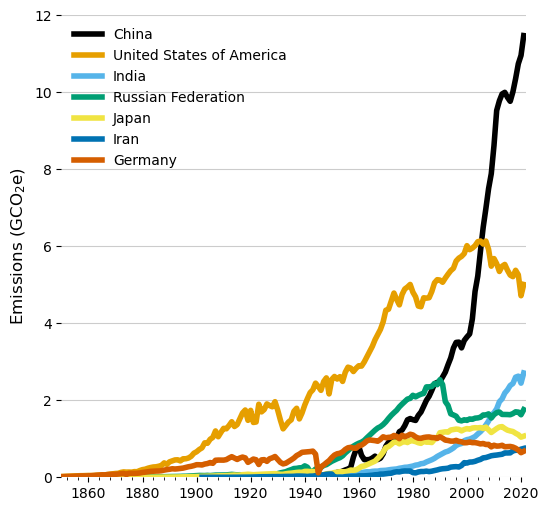

In [7]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# top 7 emitters
top_emitters = list(df_recent.head(7).actor_id)

# wong color palette (https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40)
colors = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']
    
for actor_id, color in zip(top_emitters, cycle(colors)):
    
    actor_name = df_names.loc[df_names['actor_id'] == actor_id, 'name'].values[0]
    filt = df_emissions['actor_id'] == actor_id
    df_tmp = df_emissions.loc[filt]
    
    ax.plot(np.array(df_tmp['year']), np.array(df_tmp['total_emissions']) / 10**9,
            linewidth=4,
            label = actor_name,
            color=color)

    ylim = [0, 12]
    ax.set_ylim(ylim)
    ax.set_xlim([1850, 2022])

    # Turn off the display of all ticks.
    ax.tick_params(which='both',     # Options for both major and minor ticks
                   top='off',        # turn off top ticks
                   left='off',       # turn off left ticks
                   right='off',      # turn off right ticks
                   bottom='off')     # turn off bottom ticks

    # Remove x tick marks
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # major/minor tick lines
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.grid(axis='y',
            which='major',
            color=[0.8, 0.8, 0.8], linestyle='-')

    ax.set_ylabel("Emissions (GCO$_2$e)", fontsize=12)
    ax.legend(loc='upper left', frameon=False)

This tells a richer story. Now we see the US was the main annual contributor up until about the year 2000. After which, Chinese emissions sky rocketed while US emissions started declining.

An interesting feature in this graph is the dramatic drop in Russian emissions. This corresponds to the fall of the Soviet Union, which led to a huge drop in emissions. Key drivers of the emissions reductions were the decreasing beef consumption in the 1990s and carbon sequestration in soils on abandoned cropland [Schierhorn et al., (2019)](https://iopscience.iop.org/article/10.1088/1748-9326/ab1cf1/meta).

## Emissions per capita

Let's retrieve population data and calulate emissions per capita for the seven countries with the highest annual emissions.

In [8]:
# emissions for top seven countries with highest annual emissions in 2021
df_pop = client.population(tuple(df_recent.head(7)['actor_id']))

# calculate emissions per capita
df_percap = pd.merge(df_emissions, df_pop, on=['actor_id', 'year'])[['actor_id', 'year', 'total_emissions', 'population']]
df_percap = df_percap.assign(total_emissions_per_capita = lambda x: x['total_emissions'] / (x['population']))

In [9]:
year = df_percap.year.max()
df_recent_percap = (
    df_percap
    .loc[df_percap.year == year]
    .assign(rank = lambda x: x['total_emissions_per_capita'].rank(ascending=False))
    .assign(percent_of_global = lambda x: (x['total_emissions'] / x['total_emissions'].sum()) * 100)
    .sort_values(by='rank')
    .merge(df_names, on='actor_id')
    .loc[:, ['rank', 'name', 'actor_id', 'year', 'total_emissions_per_capita', 'percent_of_global']]
)

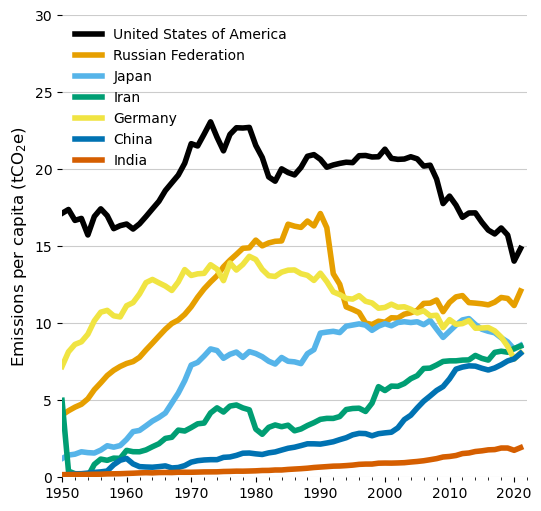

In [10]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# top 7 emitters
top_emitters = list(df_recent_percap.head(7).actor_id)

# wong color palette (https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40)
colors = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']
    
for actor_id, color in zip(top_emitters, cycle(colors)):
    
    actor_name = df_names.loc[df_names['actor_id'] == actor_id, 'name'].values[0]
    filt = df_percap['actor_id'] == actor_id
    df_tmp = df_percap.loc[filt]

    ax.plot(np.array(df_tmp['year']), np.array(df_tmp['total_emissions_per_capita']),
            linewidth=4,
            label = actor_name,
            color=color)

    ylim = [0, 30]
    ax.set_ylim(ylim)
    ax.set_xlim([1950, 2022])

    # Turn off the display of all ticks.
    ax.tick_params(which='both',     # Options for both major and minor ticks
                   top='off',        # turn off top ticks
                   left='off',       # turn off left ticks
                   right='off',      # turn off right ticks
                   bottom='off')     # turn off bottom ticks

    # Remove x tick marks
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # major/minor tick lines
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.grid(axis='y',
            which='major',
            color=[0.8, 0.8, 0.8], linestyle='-')

    ax.set_ylabel("Emissions per capita (tCO$_2$e)", fontsize=12)
    ax.legend(loc='upper left', frameon=False)

This graph shows that the average person in US emits about double the amount of CO2 annually as the average person in China, despite China having nearly 4 times the US population. 